In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as sns

In [0]:
df = pd.read_csv('DatasetConverted-v1.csv', encoding = "ISO-8859-1")
df.head()

,name/decrip,converted,lower_conv,upper_conv
0,"DIAMOND EARRINGS, TABBAH\rCircular-cut diamond...",10625.0,4000.0,6000.0
1,DIAMOND 'POWER BREAKER' CHRONOGRAPH WRISTWATCH...,10000.0,7000.0,10000.0
2,"DIAMOND, ONYX AND ENAMEL 'AMULETTE' PENDANT NE...",27500.0,4000.0,6000.0
3,"DIAMOND BROOCH, BULGARI\rCircular, pear, squar...",13750.0,7000.0,10000.0
4,"TEN GOLD AND ENAMEL BRACELETS\rRed, blue and g...",12500.0,10000.0,15000.0


In [0]:
df= df.rename(columns={"lower_conv": "price_estimate_lower", 'upper_conv': "price_estimate_upper"})

**CLEANING UP THE TEXT**

In [0]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = text.replace('x', '') #    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


In [0]:
df['name/decrip'] = df['name/decrip'].apply(clean_text)

**PREPARING MODELS**:

> **TOKENIZING**


In [0]:
!pip install tensorflow

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['name/decrip'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 67354 unique tokens.


> **FEATURES AND TARGET**




In [0]:
X = tokenizer.texts_to_sequences(df['name/decrip'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (65096, 250)


In [0]:
#SCALE target variable bc price distribution skewed
Y = np.log(df.converted)


> **TRAIN/TEST SPLIT FOR BOTH MODELS** 

1.   dtrain/test for complex model (looks at price estimates + text)
2.   X_train/test for simple model (looks only at text)



In [0]:
from sklearn.model_selection import train_test_split
dtrain, dtest,Z_train, Z_test, Y_train, Y_test = train_test_split(df.drop('converted', axis =1),X, Y, test_size = 0.10, random_state = 42)
print(dtrain.shape,Z_train.shape, Y_train.shape)
print(dtest.shape,Z_test.shape,Y_test.shape)

(58586, 3) (58586, 250) (58586,)
(6510, 3) (6510, 250) (6510,)


*MODEL 1: COMPLEX*

In [0]:
def get_keras_data1(dataset):
    mydata = {'all_sequences':Z_train
        ,'lower_bound': np.array(np.log(dataset.price_estimate_lower))
        ,'upper_bound': np.array(np.log(dataset.price_estimate_upper))
        }
    return mydata
def get_keras_data2(dataset):
    mydata = {'all_sequences':Z_test
        ,'lower_bound': np.array(np.log(dataset.price_estimate_lower))
        ,'upper_bound': np.array(np.log(dataset.price_estimate_upper))
        }
    return mydata


In [0]:
X_train = get_keras_data1(dtrain)
X_test = get_keras_data2(dtest)

In [0]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization, LSTM, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    all_sequences = Input(shape=[X_train["all_sequences"].shape[1]], name="all_sequences")

    upper = Input(shape=[1], name="upper_bound")
    lower = Input(shape=[1], name="lower_bound")
   
    #Embeddings layers
    emb_all_sequences = Embedding(MAX_NB_WORDS, EMBEDDING_DIM)(all_sequences)
    emb_lower = Embedding(50000, 50)(lower)
    emb_upper = Embedding(50000, 50)(upper)

    
    #rnn layer
    rnn_layer1 = Bidirectional(LSTM(150))(emb_all_sequences)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_all_sequences)
        , Flatten() (emb_lower)
        , Flatten() (emb_upper)
        , rnn_layer1

    ])
    main_l = Dropout(dr_r) (Dense(16) (main_l))
    #main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="relu") (main_l)
    
    #model
    model = Model([all_sequences, lower, upper], output)
    model.compile(optimizer = 'adam', loss="mse")
    
    return model

    
model = get_model()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
all_sequences (InputLayer)      (None, 250)          0                                            
__________________________________________________________________________________________________
lower_bound (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
upper_bound (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 300)     15000000    all_se

In [0]:
epochs = 3

model = get_model()
history1 = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 46868 samples, validate on 11718 samples
Epoch 1/3





46868/46868 [==============================] - 2171s 46ms/step - loss: 1.5478 - val_loss: 0.7429
Epoch 2/3
 7104/46868 [===>..........................] - ETA: 29:18 - loss: 1.4536

Evaluate Model 1

In [0]:
test_loss = model.evaluate(X_test,Y_test)
rms = np.sqrt(test_loss)
print('complex model score {}'.format(rms))

6510/6510 [==============================] - 82s 13ms/step
complex model score 0.6222625568052527


In [0]:
val_preds = model.predict(X_test)


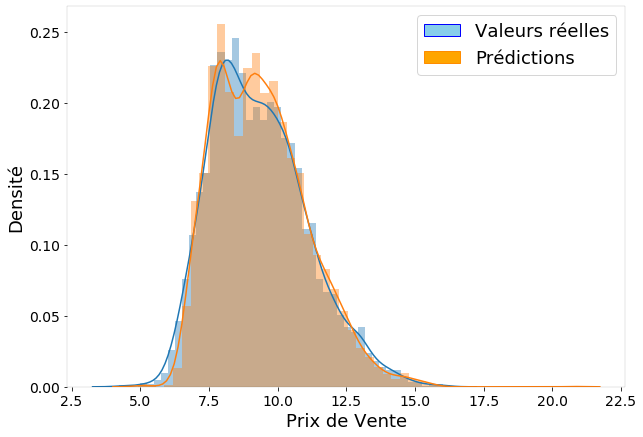

In [0]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor = 'skyblue', edgecolor = 'b', label = 'Valeurs réelles'),
                   Patch(facecolor='orange', edgecolor='darkorange',
                         label='Prédictions')]


matplotlib.rcParams['axes.linewidth'] = 0.1
plt.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 


plt.figure(figsize=(10,7))
sns.distplot(Y_test)
sns.distplot(val_preds)
plt.xlabel('Prix de Vente')
plt.ylabel('Densité')
plt.legend(handles=legend_elements)


In [0]:
predictions = pd.DataFrame({'preds': np.exp(val_preds.ravel()).round(),'true': np.exp(Y_test)})
predictions.head()

*MODEL 2: SIMPLE*

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, dropout=0.3, recurrent_dropout=0.3)))


model.add(tf.keras.layers.Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

epochs = 5
batch_size = 32

history2 = model.fit(Z_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)


Evaluate Model 2

In [0]:
z_test_loss = model.evaluate(Z_test,Y_test)
print('simple model score: {}'.format(np.sqrt(z_test_loss)[0]))

In [0]:
matplotlib.rcParams['axes.linewidth'] = 0.1
plt.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
plt.figure(figsize=(10,7))
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.ylabel('Loss: MSE')
plt.xlabel('Time')
plt.legend()
plt.show();

In [0]:
y_pred = model.predict(Z_test)

In [0]:
legend_elements = [Patch(facecolor = 'skyblue', edgecolor = 'b', label = 'Predictions'),
                   Patch(facecolor='orange', edgecolor='darkorange',
                         label='Valeurs réelles')]

In [0]:
matplotlib.rcParams['axes.linewidth'] = 0.1
plt.figure(figsize=(10,7))
sns.distplot(Y_test)
sns.distplot(y_pred)
plt.xlabel('Prix de Vente')
plt.ylabel('Densité')
plt.legend(handles=legend_elements)

In [0]:
predictions2 = pd.DataFrame({'preds': np.exp(y_pred),'true': np.exp(Y_test)})
predictions2.head()